Mi codigo puede ser :
- el mio,
- inspirado de esta creadora https://github.com/LeCoinStat
- inspirado de este creador https://github.com/codebasics
- alguna parte que indicaré con IA
- he tambien mirado la documentacion de xgboost y lightgbm

In [ ]:
# -----------------------------------
# 🚫 Suppression des warnings
# -----------------------------------
import warnings
warnings.filterwarnings("ignore")

# -----------------------------------
# 📦 Manipulation des données
# -----------------------------------
import pandas as pd
import numpy as np

# -----------------------------------
# 🧪 Statistiques & distributions
# -----------------------------------
from scipy.stats import randint, uniform, loguniform

# -----------------------------------
# 📊 Visualisation
# -----------------------------------
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# -----------------------------------
# 💾 Sauvegarde & chargement
# -----------------------------------
import pickle

# -----------------------------------
# ⚙️ Prétraitement
# -----------------------------------
from sklearn.preprocessing import OneHotEncoder, RobustScaler, MinMaxScaler
from category_encoders import TargetEncoder
from sklearn.base import BaseEstimator, TransformerMixin

# -----------------------------------
# 🔁 Sélection de modèle & pipeline
# -----------------------------------
from sklearn.model_selection import (
    train_test_split, StratifiedKFold,
    GridSearchCV, RandomizedSearchCV,
    learning_curve
)
from sklearn.pipeline import Pipeline

# -----------------------------------
# 📈 Évaluation & métriques
# -----------------------------------
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, classification_report,
    precision_recall_curve, auc, confusion_matrix
)
from sklearn.inspection import permutation_importance
from sklearn.utils.class_weight import compute_class_weight

# -----------------------------------
# 🧠 Modèles Scikit-learn
# -----------------------------------
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# -----------------------------------
# 🚀 Modèles Boosting
# -----------------------------------
import xgboost as xgb
import lightgbm as lgb

# -----------------------------------
# ⚖️ Gestion du déséquilibre de classes
# -----------------------------------
from imblearn.over_sampling import SMOTE

# -----------------------------------
# 🤖 Deep Learning (TensorFlow / Keras)
# -----------------------------------
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.base import ClassifierMixin


In [95]:
df_raw = pd.read_csv(r"../Data\income_data.csv")

In [96]:
df_raw.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'educational-num',
       'marital-status', 'occupation', 'relationship', 'race', 'gender',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'income'],
      dtype='object')

In [ ]:
df_processed = df_raw.copy()

# Transformacion de la variable target tipo labelencoding
df_processed["income"] = df_processed["income"].map({"<=50K": 0, ">50K": 1}) 

# Tratamiento

In [ ]:
# Creacion de la variable continent para reducir la cardinalidad de la variable "native-country"

continent_map = {
    "United-States": "Amérique du Nord",
    "Canada": "Amérique du Nord",
    "Puerto-Rico": "Amérique du Nord",
    "Outlying-US(Guam-USVI-etc)": "Amérique du Nord",
    "Cuba": "Amérique du Nord",
    "Dominican-Republic": "Amérique du Nord",
    "Haiti": "Amérique du Nord",
    "Jamaica": "Amérique du Nord",
    "Mexico": "Amérique du Nord",
    "El-Salvador": "Amérique du Nord",
    "Honduras": "Amérique du Nord",
    "Guatemala": "Amérique du Nord",
    "Nicaragua": "Amérique du Nord",
    "Trinadad&Tobago": "Amérique du Nord",

    "Columbia": "Amérique du Sud",
    "Ecuador": "Amérique du Sud",
    "Peru": "Amérique du Sud",

    "England": "Europe",
    "France": "Europe",
    "Germany": "Europe",
    "Greece": "Europe",
    "Ireland": "Europe",
    "Italy": "Europe",
    "Poland": "Europe",
    "Portugal": "Europe",
    "Scotland": "Europe",
    "Yugoslavia": "Europe",
    "Hungary": "Europe",
    "Holand-Netherlands": "Europe",

    "India": "Asie",
    "Iran": "Asie",
    "Philippines": "Asie",
    "Vietnam": "Asie",
    "China": "Asie",
    "Cambodia": "Asie",
    "Thailand": "Asie",
    "Laos": "Asie",
    "Japan": "Asie",
    "Hong": "Asie",
    "Taiwan": "Asie",

    "South": "Africa",
}


In [ ]:
# He creado tres clases de transformadores para el preprocesamiento de datos: NewFeature, Encoder y CustomRobustScaler.

# Esta clase permite crear nuevas caracteristicas y eliminarlas que no utilizo.
class NewFeature(BaseEstimator, TransformerMixin):

    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X["continent"] = X["native-country"].map(continent_map)
        X["P&L"] = X["capital-gain"] - X["capital-loss"]
        X["race-group"] = X["race"].apply(lambda x: "White" if x == "White" else "Other")
        X = X.drop(columns=['education', 'marital-status', 'capital-loss', 'capital-gain',"native-country","fnlwgt","race"])
        return X


# Esta clase se encarga de codificar las variables categoricas, tanto las que tienen un alto cardinalidad como las que no.
class Encoder(BaseEstimator, TransformerMixin):

    def __init__(self):
        self.target_cols = ['workclass', 'occupation', 'relationship', 'race-group', "continent"] # Target encoding aqui porque tenemos muchas categorias
        self.onehot_cols = ['gender'] # OneHotEncoder aunque se puede hacer label o solo un replace, pero si hay otros valores en el futuro va a ignorarlos
        self.target_encoder = None
        self.onehot_encoder = None

    def fit(self, X, y):
        X = X.copy()

     
        self.target_encoder = TargetEncoder()
        self.target_encoder.fit(X[self.target_cols], y)

     
        self.onehot_encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
        self.onehot_encoder.fit(X[self.onehot_cols])

        return self

    def transform(self, X):
        X = X.copy()

     
        if self.target_cols and self.target_encoder is not None:
            X[self.target_cols] = self.target_encoder.transform(X[self.target_cols])

    
        if self.onehot_cols and self.onehot_encoder is not None:
            onehot_encoded = self.onehot_encoder.transform(X[self.onehot_cols])
            onehot_feature_names = self.onehot_encoder.get_feature_names_out(self.onehot_cols)
            onehot_df = pd.DataFrame(onehot_encoded, columns=onehot_feature_names, index=X.index)

            X = X.drop(columns=self.onehot_cols)
            X = pd.concat([X, onehot_df], axis=1)

        return X


# Esta clase se encarga de escalar las variables numericas, en este caso utilizo
# el RobustScaler porque es menos sensible a los outliers

class CustomRobustScaler(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        # Colonnes à scaler directement définies ici
        self.num_cols = ['age', 'educational-num', 'hours-per-week', 'P&L']
        self.scaler = RobustScaler()
    
    def fit(self, X, y=None):
        X = X.copy()
        self.scaler.fit(X[self.num_cols])
        return self
    
    def transform(self, X):
        X = X.copy()
        X_scaled = self.scaler.transform(X[self.num_cols])
        X_scaled_df = pd.DataFrame(X_scaled, columns=self.num_cols, index=X.index)
        X[self.num_cols] = X_scaled_df
        return X

## Nulos

In [ ]:
# Eliminamos las filas con valores nulos y los valores extranos de las columnas "workclass", "occupation" y "native-country"
cols_with_error = ["workclass", "occupation", "native-country"]

df_processed =  df_processed[df_processed["workclass"] != "Never-worked"]
df_processed =  df_processed[df_processed["workclass"] != "Without-pay"]
df_processed =  df_processed[df_processed["race"] != "Other"]

# Imputamos los valores extranas con la moda ("?")
for col in cols_with_error:
    mode = df_processed.loc[df_processed[col] != '?', col].mode()[0]
    df_processed[col] = df_processed[col].replace('?', mode)

## Outliers

In [ ]:
# Isolamos la variable fnlwgt para el calculo de los weights por registros para aportar mas representatividad al modelo
sample_weights = df_processed['fnlwgt']

In [ ]:
# Creacion del dataset de train y test, con un 80% para el train
# y un 20% para el test, seperamaos tambien los weights sin olvidar el stratify.
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(
    df_processed.drop(columns=["income"]),
    df_processed["income"],
    sample_weights,
    test_size=0.2,
    random_state=42,
    stratify=df_processed["income"],
)

In [ ]:
# Windsoriacion de las variables con outliers consicuentes con valores que hemos visto en la EDA
print(X_train.shape)
X_train['capital-gain'] = X_train['capital-gain'].clip(upper=20000)
X_train['hours-per-week'] = X_train['hours-per-week'].clip(upper=60)
X_train['age'] = X_train['age'].clip(upper=65)
X_train['capital-loss'] = X_train['capital-loss'].clip(upper=3000)
print(X_train.shape)

(38724, 14)
(38724, 14)


# Data processing

In [ ]:
# Pipeline de preprocesamiento de datos
full_pipeline = Pipeline([
    ('feature_engineering', NewFeature()),
    ('encoding', Encoder()),
    ('scaling', CustomRobustScaler())
])

In [105]:
X_train.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'educational-num',
       'marital-status', 'occupation', 'relationship', 'race', 'gender',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')

In [ ]:
# Pasamos el fit solo sobre el dataset de train, para evitar el leakage de datos
full_pipeline.fit(X_train, y_train)
X_train = full_pipeline.transform(X_train)
X_test = full_pipeline.transform(X_test)

In [27]:
X_train

,age,workclass,educational-num,occupation,relationship,hours-per-week,continent,P&L,race-group,gender_Male
32847,-0.70,0.209596,1.000000,0.340543,0.100560,3.0,0.239361,0.0,0.254513,1.0
47503,-0.35,0.209596,0.000000,0.133513,0.060381,0.0,0.239361,0.0,0.152587,0.0
46561,-0.60,0.209596,-0.333333,0.210184,0.450128,1.0,0.239361,0.0,0.254513,1.0
34437,-0.40,0.385435,1.000000,0.340543,0.100560,0.0,0.239361,0.0,0.254513,0.0
26968,-0.20,0.209596,0.000000,0.340543,0.450128,0.0,0.239361,0.0,0.254513,1.0
...,...,...,...,...,...,...,...,...,...,...
18300,-0.70,0.209596,-1.000000,0.228103,0.014606,0.0,0.239361,0.0,0.254513,1.0
45175,-0.60,0.209596,0.000000,0.283170,0.100560,2.0,0.239361,2174.0,0.152587,0.0
13066,1.40,0.298329,1.333333,0.480777,0.450128,-4.0,0.239361,0.0,0.254513,1.0
24582,0.70,0.209596,1.000000,0.480777,0.450128,0.0,0.239361,0.0,0.254513,1.0


In [ ]:
# Lo que hago aqui y tambien antes es solo imputar los outliers
# en train pero no en test pero necesito el dataset de validation preparado como el de train

X_train, X_val, y_train, y_val,w_train, w_val  = train_test_split(
    X_train,
    y_train,
    w_train,
    test_size=0.2,
    random_state=42,
    stratify=y_train
)

# Train default models

En primer lugar vamos a probar los modelos basicos sin ajuste de hyperparametros (baseline)

Vamos a mirar especialemente el PR AUC al reves del ROC AUC porque el ROC AUC puede ser alto y bueno pero no toma en consideracion que tenemos una clase positiva desbalanceada. Asi en este caso, prefiero mirar el PR AUC sin olvidar de ver el ROC AUC.

Otra metrica que voy a mirar tambien es el F1 score de la clase positiva pero tambien el F1 score weighted para saber como mi modelo maneja la clase desbalanceada y el modelo gobal tomando en cuenta que tengo una clase desbalanceada.

In [ ]:
# Creacion de un dataset para seguir las metricas de los modelos sobre el dataset de validation
df_metrics_valid= pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score class 1', 'F1 Score macro', 'F1 Score weighted', 'ROC AUC', 'PR AUC'])

In [ ]:
def dataframe_metrics(model, X, y, model_name=None, df_metrics=None, threshold=0.5)-> pd.DataFrame:
    """
    Funcion para calcular las metricas de los modelos con cualquier dataset

    ---------------------------------------
    Parameters:

    model : nuestro model
    X : las variables independentes de nuestro dataset sin la target
    y : la target de nuestro dataset
    model_name : nombre del modelo para utilizarlo en cualquier momento
    df_metrics : dataframe donde se guardan las metricas de los modelos
    threshold : si queremos cambiar el threshold de la prediccion, por defaut 0.5

    ---------------------------------------
    Returns:

    df_metrics : dataframe con las metricas de los modelos

    """
    y_pred = model.predict(X)

    if hasattr(model, "predict"):
        y_pred_proba = model.predict(X)  
        y_pred_classes = (y_pred_proba >= threshold).astype(int)  
    else:
       
        y_pred_classes = model.predict(X)

   



    

    y_pred_prob = model.predict_proba(X)

   # La IA me ha ayudado aqui porque con la red neuronal no tenemos la misma cosa que los otros modelos
    if y_pred_prob.shape[1] == 2:
        y_pred_prob = y_pred_prob[:, 1]  
    else:  
        y_pred_prob = y_pred_prob[:, 0]
    
    precision, recall, thresholds = precision_recall_curve(y, y_pred_prob)

    
    pr_auc = auc(recall, precision) # la metrica que vamos a mirar 
    roc_auc = roc_auc_score(y, y_pred_proba)
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred, average='binary')
    recall = recall_score(y, y_pred, average='binary')
    f1 = f1_score(y, y_pred, pos_label=1) # el F1 score solo para la clase 1 (la positiva, >50K)
    f1_global = f1_score(y, y_pred, average='macro') # el F1 score global
    f1_weighted = f1_score(y, y_pred, average='weighted') # el F1 score global ponderado

    
    results = pd.DataFrame([{
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score class 1': f1,
        'F1 Score macro': f1_global,
        'F1 Score weighted': f1_weighted,
        'ROC AUC': roc_auc,
        'PR AUC': pr_auc
    }])

    
    if df_metrics is None:
        df_metrics = results
    else:
        df_metrics = pd.concat([df_metrics, results], ignore_index=True)
    
    return df_metrics

In [ ]:
logistic_reg = LogisticRegression(max_iter=2000, random_state=42)
logistic_reg.fit(X_train, y_train)


df_metrics_valid = dataframe_metrics(logistic_reg,X_val, y_val, model_name="logistic_reg", df_metrics=df_metrics_valid)


In [ ]:
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, y_train)


df_metrics_valid = dataframe_metrics(decision_tree,X_val, y_val, model_name="decision_tree",df_metrics=df_metrics_valid)


In [33]:
random_forest = RandomForestClassifier(random_state=42, n_jobs=-1)
random_forest.fit(X_train, y_train)

df_metrics_valid = dataframe_metrics(random_forest,X_val, y_val, model_name="random_forest",df_metrics=df_metrics_valid)


In [34]:
adaboost = AdaBoostClassifier()
adaboost.fit(X_train, y_train)

df_metrics_valid = dataframe_metrics(adaboost, X_val, y_val, model_name="adaboost",df_metrics=df_metrics_valid)


In [35]:
xgboost = xgb.XGBClassifier(eval_metric='aucpr')
xgboost.fit(X_train, y_train)

df_metrics_valid = dataframe_metrics(xgboost,X_val, y_val, model_name="xgboost",df_metrics=df_metrics_valid)


In [36]:
lgbm = lgb.LGBMClassifier(random_state=42, objective='binary', metric="auc",)
lgbm.fit(X_train, y_train)

df_metrics_valid = dataframe_metrics(lgbm, X_val, y_val, model_name="lgbm",df_metrics=df_metrics_valid)


[LightGBM] [Info] Number of positive: 7446, number of negative: 23533
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001868 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 327
[LightGBM] [Info] Number of data points in the train set: 30979, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.240356 -> initscore=-1.150727
[LightGBM] [Info] Start training from score -1.150727


In [37]:
KNN = KNeighborsClassifier(n_neighbors=5)
KNN.fit(X_train, y_train)

df_metrics_valid = dataframe_metrics(KNN,X_val, y_val, model_name="KNN",df_metrics=df_metrics_valid)


In [38]:
df_metrics_valid= df_metrics_valid.reset_index(drop=True)
df_metrics_valid.sort_values(by='PR AUC', ascending=False)

,Model,Accuracy,Precision,Recall,F1 Score class 1,F1 Score macro,F1 Score weighted,ROC AUC,PR AUC
5,lgbm,0.879793,0.800905,0.665414,0.726899,0.824918,0.875807,0.806530,0.844633
4,xgboost,0.881214,0.799238,0.675618,0.732247,0.827962,0.877654,0.810952,0.840674
3,adaboost,0.861975,0.782206,0.590226,0.672788,0.792665,0.854902,0.769106,0.793352
6,KNN,0.858748,0.731325,0.651987,0.689381,0.798985,0.855889,0.788088,0.785651
2,random_forest,0.856811,0.726671,0.648228,0.685211,0.796270,0.853929,0.785528,0.781811
0,logistic_reg,0.844287,0.720727,0.575188,0.639785,0.770230,0.837954,0.752323,0.747858
1,decision_tree,0.830084,0.649835,0.635875,0.642780,0.765655,0.829449,0.763714,0.689054


In [ ]:
# Aqui la IA me ayudaba tambien porque para calcular el ROC AUC y el PR AUC necesitaba 
# predict_proba y tambien predict depiendo del caso, por eso he hecho una clase para el modelo de Keras con un wrapper.

class KerasClassifierWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, build_fn, epochs=30, batch_size=32, verbose=0):
        self.build_fn = build_fn
        self.epochs = epochs
        self.batch_size = batch_size
        self.verbose = verbose
        self.model = None

    def fit(self, X, y):
        self.classes_ = np.unique(y)
        self.model = self.build_fn()
        self.model.fit(X, y, epochs=self.epochs, batch_size=self.batch_size, verbose=self.verbose)
        return self

    def predict(self, X):
        preds = self.model.predict(X)
        return (preds > 0.5).astype(int)

    def predict_proba(self, X):
        return self.model.predict(X)

# el dropout rate aqui me permite no tener overfitting, por eso lo he puesto a 0.2
# y tengo una activacion sigmoid al final y no softmax porque es un problema de clasificacion binaria
def create_dense_model():
    model = Sequential()
    model.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))  
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['binary_accuracy'])
    return model


rnn_model = KerasClassifierWrapper(build_fn=create_dense_model, epochs=30, batch_size=32, verbose=1)


rnn_model.fit(X_train, y_train)



df_metrics_valid = dataframe_metrics(rnn_model, X_val, y_val, model_name="rnn_model", df_metrics=df_metrics_valid)



Epoch 1/30
969/969 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - binary_accuracy: 0.7784 - loss: 8.6040
Epoch 2/30
969/969 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - binary_accuracy: 0.8081 - loss: 0.4781
Epoch 3/30
969/969 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - binary_accuracy: 0.8158 - loss: 0.3795
Epoch 4/30
969/969 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - binary_accuracy: 0.8204 - loss: 0.3692
Epoch 5/30
969/969 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - binary_accuracy: 0.8181 - loss: 0.3746
Epoch 6/30
969/969 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - binary_accuracy: 0.8196 - loss: 0.3628
Epoch 7/30
969/969 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - binary_accuracy: 0.8208 - loss: 0.3627
Epoch 8/30
969/969 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - binary_accuracy: 0.8197 - loss: 0.3579
Epoch 9/30
969/969 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - binary_accuracy: 0.8163 - loss: 0.3629
Epoch 10/30
969/969 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - binary_accuracy: 0.8165 - loss: 0.3571
Epoch 11/30
969/969 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - binary_accurac

In [40]:
y_pred = rnn_model.predict(X_val)
print(classification_report(y_val, y_pred))

243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
              precision    recall  f1-score   support

           0       0.86      0.92      0.89      5883
           1       0.68      0.53      0.60      1862

    accuracy                           0.83      7745
   macro avg       0.77      0.73      0.75      7745
weighted avg       0.82      0.83      0.82      7745



In [41]:
df_metrics_valid.sort_values(by='PR AUC', ascending=False)

,Model,Accuracy,Precision,Recall,F1 Score class 1,F1 Score macro,F1 Score weighted,ROC AUC,PR AUC
5,lgbm,0.879793,0.800905,0.665414,0.726899,0.824918,0.875807,0.806530,0.844633
4,xgboost,0.881214,0.799238,0.675618,0.732247,0.827962,0.877654,0.810952,0.840674
3,adaboost,0.861975,0.782206,0.590226,0.672788,0.792665,0.854902,0.769106,0.793352
6,KNN,0.858748,0.731325,0.651987,0.689381,0.798985,0.855889,0.788088,0.785651
2,random_forest,0.856811,0.726671,0.648228,0.685211,0.796270,0.853929,0.785528,0.781811
0,logistic_reg,0.844287,0.720727,0.575188,0.639785,0.770230,0.837954,0.752323,0.747858
7,rnn_model,0.828793,0.684319,0.534372,0.600121,0.745600,0.821129,0.728175,0.732543
1,decision_tree,0.830084,0.649835,0.635875,0.642780,0.765655,0.829449,0.763714,0.689054


## Feature importance

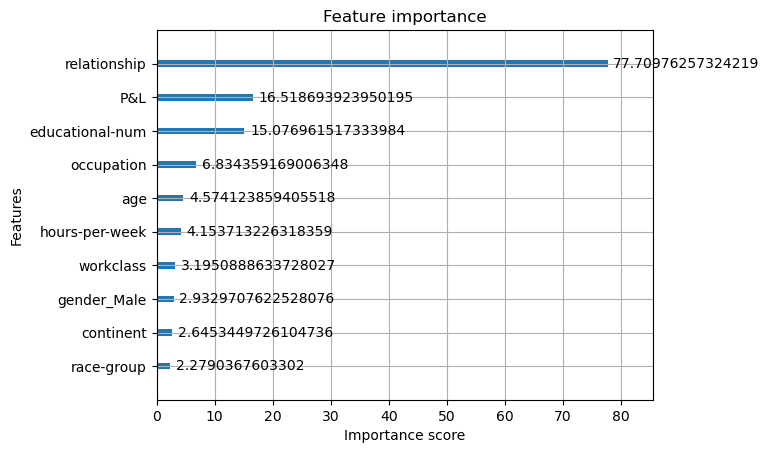

In [42]:
xgb.plot_importance(xgboost, importance_type='gain') 
plt.show()

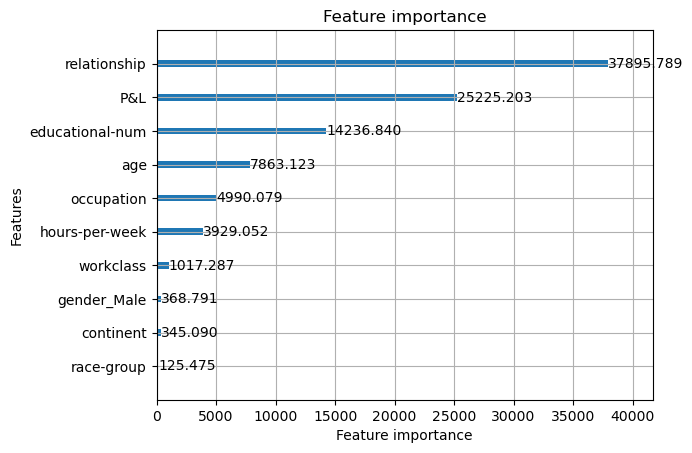

In [ ]:

lgb.plot_importance(lgbm, importance_type='gain')
plt.show()

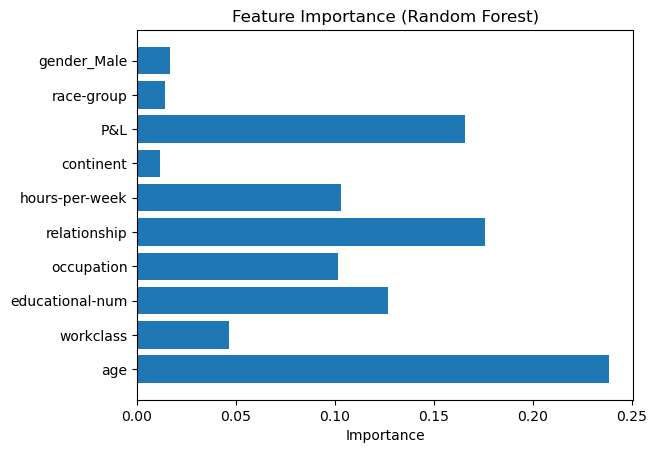

In [ ]:
importances = random_forest.feature_importances_


plt.barh(range(len(importances)), importances)
plt.yticks(range(len(importances)), X_train.columns)
plt.xlabel('Importance')
plt.title('Feature Importance (Random Forest)')
plt.show()

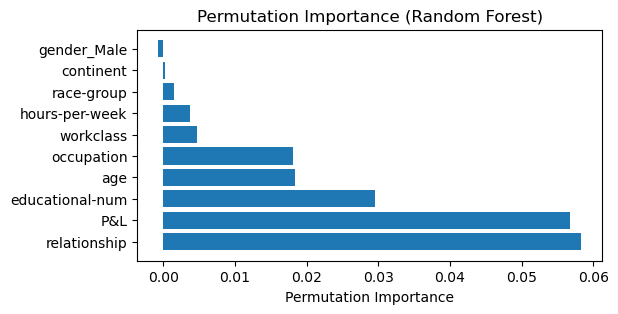

In [ ]:
# Otra manera de calcular la importancia de las variables es con el Permutation Importance
# que permite permutar las variables y ver el impacto en la prediccion
# la IA y una video en youtube me ayudaron a entenderlo y hacerlo
result = permutation_importance(random_forest, X_val, y_val, n_repeats=10, random_state=42)


perm_importance = result.importances_mean
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Permutation Importance': perm_importance
})

importance_df = importance_df.sort_values(by='Permutation Importance', ascending=False)


plt.figure(figsize=(6, 3))
plt.barh(importance_df['Feature'], importance_df['Permutation Importance'])
plt.xlabel('Permutation Importance')
plt.title('Permutation Importance (Random Forest)')
plt.show()


Se puede ver con los diferentes graficos que continent, race-group y gender no permiten predicir bien la target. No tenemos muchas variables aqui asi podemos guardar esas variables y al mismo tiempo podremos decir que hemos tenido en cuenta la raza, le genero y el pais de origen. De esta manera podremos mostrar que son variables no determinentes para predicir el sueldo.

## Verification con dataset de test

In [46]:
df_metrics_test= pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score class 1', 'F1 Score macro', 'F1 Score weighted', 'ROC AUC', 'PR AUC'])

In [47]:
models = {
    'logistic_reg': logistic_reg,
    'decision_tree': decision_tree,
    'random_forest': random_forest,
    'adaboost': adaboost,
    'xgboost': xgboost,
    'lgbm': lgbm,
    'KNN': KNN,
    'rnn_model': rnn_model
}

for model_name, model in models.items():
    df_metrics_test = dataframe_metrics(model,X_test, y_test, model_name=model_name, df_metrics=df_metrics_test)



303/303 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
303/303 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
303/303 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [ ]:

df_metrics_test= df_metrics_test.reset_index(drop=True)
df_metrics_test.sort_values(by='PR AUC', ascending=False)

,Model,Accuracy,Precision,Recall,F1 Score class 1,F1 Score macro,F1 Score weighted,ROC AUC,PR AUC
5,lgbm,0.873050,0.784161,0.651053,0.711435,0.815030,0.868823,0.797175,0.829551
4,xgboost,0.870571,0.769308,0.659218,0.710021,0.813358,0.867017,0.798333,0.825396
3,adaboost,0.855593,0.774365,0.563386,0.652239,0.780558,0.847190,0.755721,0.781061
6,KNN,0.851358,0.715534,0.633434,0.671985,0.787946,0.848160,0.776875,0.768882
2,random_forest,0.845574,0.700772,0.623979,0.660150,0.780118,0.842414,0.769836,0.759567
0,logistic_reg,0.843714,0.717182,0.577568,0.639848,0.770026,0.837623,0.752749,0.733422
7,rnn_model,0.827807,0.682522,0.530297,0.596856,0.743690,0.819935,0.726122,0.724140
1,decision_tree,0.813965,0.615452,0.602492,0.608903,0.743430,0.813285,0.741687,0.658136


Vamos a guardar los modelos lgbm, xgboost. Vamos tambien a probar diferentes hyperparametros para optimizar nuestros modelos.

Segun los diferentes modelos, las variables las mas importantes son relationship, P&L, education-num, age and occupation.

# Use of SMOTE with default model

In [ ]:
# Utilizar el SMOTE para equilibrar las clases en el dataset de train
# con 5 vecinos para evitar el overfitting y un random_state para la reproducibilidad
smote = SMOTE(random_state=42, sampling_strategy='minority', k_neighbors=5)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

NameError: name 'SMOTE' is not defined

In [50]:
models = {
    'random_forest_smote': random_forest,
    'adaboost_smote': adaboost,
    'xgboost_smote': xgboost,
    'lgbm_smote': lgbm,
    'KNN_smote': KNN,
    'rnn_model_smote': rnn_model
}

for model_name, model in models.items():
    print(model_name)
    model.fit(X_train_smote, y_train_smote)
    df_metrics_valid = dataframe_metrics(model,X_val, y_val, model_name=model_name, df_metrics=df_metrics_valid)


random_forest_smote
adaboost_smote
xgboost_smote
lgbm_smote
[LightGBM] [Info] Number of positive: 23533, number of negative: 23533
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001785 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2462
[LightGBM] [Info] Number of data points in the train set: 47066, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
KNN_smote
rnn_model_smote
Epoch 1/30
1471/1471 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - binary_accuracy: 0.7527 - loss: 7.6765
Epoch 2/30
1471/1471 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - binary_accuracy: 0.7947 - loss: 0.4530
Epoch 3/30
1471/1471 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - binary_accuracy: 0.8011 - loss: 0.4266
Epoch 4/30
1471/1471 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - binary_accuracy: 0.7996 - loss: 0.4234
Epoch 5/30
1471/1471 ━━━━━━━━━━

In [51]:
df_metrics_valid.sort_values(by='PR AUC', ascending=False)

,Model,Accuracy,Precision,Recall,F1 Score class 1,F1 Score macro,F1 Score weighted,ROC AUC,PR AUC
5,lgbm,0.879793,0.800905,0.665414,0.726899,0.824918,0.875807,0.806530,0.844633
11,lgbm_smote,0.873079,0.719640,0.773362,0.745535,0.830495,0.874604,0.839001,0.843143
4,xgboost,0.881214,0.799238,0.675618,0.732247,0.827962,0.877654,0.810952,0.840674
10,xgboost_smote,0.869464,0.717203,0.754565,0.735410,0.824385,0.870579,0.830198,0.840082
3,adaboost,0.861975,0.782206,0.590226,0.672788,0.792665,0.854902,0.769106,0.793352
9,adaboost_smote,0.817431,0.584913,0.828679,0.685778,0.778558,0.826727,0.821275,0.792735
6,KNN,0.858748,0.731325,0.651987,0.689381,0.798985,0.855889,0.788088,0.785651
2,random_forest,0.856811,0.726671,0.648228,0.685211,0.796270,0.853929,0.785528,0.781811
8,random_forest_smote,0.849709,0.690502,0.679377,0.684894,0.793108,0.849290,0.791499,0.767906
12,KNN_smote,0.821433,0.597477,0.788400,0.679787,0.777992,0.828978,0.810144,0.754634


# Train with class auto-balanced

Como tenemos un dataset desbalanceado, hemos intentado hacer que ya no tenemos debalanceo con SMOTE pero con esta estrategia hemos creado datos sinteticos no sabemos si representa bien la realidad.

Asi, intentamos guardar el debalanceo pero ajustamos los peso "de error" para que nuestra clase desbalanceada tiene la misma importancia que la clase negativa al final. Podemos ajustar estos peso a mano con formula o utilizar peso automaticos encontrados por el modelo baseline con un parametro class_weight (es un poco diferente para xgboost y lightgbm).

In [52]:
random_forest_balanced = RandomForestClassifier(class_weight='balanced', random_state=42)


random_forest_balanced.fit(X_train, y_train)

df_metrics_valid = dataframe_metrics(random_forest_balanced,X_val, y_val, model_name="random_forest_balanced",df_metrics=df_metrics_valid)


In [53]:
scale_pos_weight = len(y_train) / (2 * np.bincount(y_train)[1])


xgboost_balanced = xgb.XGBClassifier(objective='binary:logistic', eval_metric='aucpr', scale_pos_weight=scale_pos_weight,random_state=42, n_estimators = 1000)
xgboost_balanced.fit(X_train, y_train)


df_metrics_valid = dataframe_metrics(xgboost_balanced,X_val, y_val, model_name="xgboost_balanced",df_metrics=df_metrics_valid)


In [54]:
lgbm_balanced = lgb.LGBMClassifier(is_unbalance=True, n_estimators=1000,random_state=42,objective='binary', metric="auc")


lgbm_balanced.fit(X_train, y_train)

df_metrics_valid = dataframe_metrics(lgbm_balanced,X_val, y_val, model_name="lgbm_balanced",df_metrics=df_metrics_valid)


[LightGBM] [Info] Number of positive: 7446, number of negative: 23533
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001019 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 327
[LightGBM] [Info] Number of data points in the train set: 30979, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.240356 -> initscore=-1.150727
[LightGBM] [Info] Start training from score -1.150727


In [55]:
knn_balanced = KNeighborsClassifier(weights='distance')


knn_balanced.fit(X_train, y_train)

df_metrics_valid = dataframe_metrics(knn_balanced,X_val, y_val, model_name="knn_balanced",df_metrics=df_metrics_valid)


In [56]:

logistic_reg_balanced = LogisticRegression(class_weight='balanced',random_state=42)
logistic_reg_balanced.fit(X_train, y_train)

df_metrics_valid = dataframe_metrics(logistic_reg_balanced,X_val, y_val, model_name="logistic_reg_balanced",df_metrics=df_metrics_valid)


In [58]:
df_metrics_valid.sort_values(by='PR AUC', ascending=False)

,Model,Accuracy,Precision,Recall,F1 Score class 1,F1 Score macro,F1 Score weighted,ROC AUC,PR AUC
5,lgbm,0.879793,0.800905,0.665414,0.726899,0.824918,0.875807,0.806530,0.844633
11,lgbm_smote,0.873079,0.719640,0.773362,0.745535,0.830495,0.874604,0.839001,0.843143
4,xgboost,0.881214,0.799238,0.675618,0.732247,0.827962,0.877654,0.810952,0.840674
10,xgboost_smote,0.869464,0.717203,0.754565,0.735410,0.824385,0.870579,0.830198,0.840082
16,lgbm_balanced,0.840542,0.628116,0.825456,0.713391,0.801468,0.847195,0.835387,0.829679
15,xgboost_balanced,0.852292,0.672430,0.751880,0.709939,0.805429,0.855004,0.817976,0.812112
3,adaboost,0.861975,0.782206,0.590226,0.672788,0.792665,0.854902,0.769106,0.793352
9,adaboost_smote,0.817431,0.584913,0.828679,0.685778,0.778558,0.826727,0.821275,0.792735
6,KNN,0.858748,0.731325,0.651987,0.689381,0.798985,0.855889,0.788088,0.785651
2,random_forest,0.856811,0.726671,0.648228,0.685211,0.796270,0.853929,0.785528,0.781811


Esto nos permite solo tener un bueno recall pero la precision baja comparando al modelo baseline. Los modelos smote tienen mejor resultados.

# Using fnlwgt

En nuestro dataset original tenemos una variable fnlwgt que permite aportar mas representatividad el modelo. Por ejemplo si una persona representa 30 000 persona en la poblacion encuestada, tendremos un fnlwgt de 30 000. Podemos ajustar los pesos para las clases pero tambien para los registros. Asi utilizo esta variable para ajustar los pesos de registros : un vez sin normalizarlos otra basica.

In [59]:
scaler = MinMaxScaler()
w_train_scaled = scaler.fit_transform(w_train.values.reshape(-1, 1)).flatten()
w_val_scaled = scaler.transform(w_val.values.reshape(-1, 1)).flatten()

In [60]:
xgboost_balanced_fnlwgt_normalized = xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, eval_metric='aucpr', scale_pos_weight=scale_pos_weight, random_state=42)
xgboost_balanced_fnlwgt_normalized.fit(X_train, y_train, sample_weight=w_train_scaled)

df_metrics_valid = dataframe_metrics(xgboost_balanced_fnlwgt_normalized,X_val, y_val, model_name="xgboost_balanced_fnlwgt_normalized",df_metrics=df_metrics_valid)


In [61]:
xgboost_balanced_fnlwgt = xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, eval_metric='aucpr', scale_pos_weight=scale_pos_weight, random_state=42)
xgboost_balanced_fnlwgt.fit(X_train, y_train, sample_weight=w_train)

df_metrics_valid = dataframe_metrics(xgboost_balanced_fnlwgt,X_val, y_val, model_name="xgboost_balanced_fnlwgt",df_metrics=df_metrics_valid)


In [62]:
lgbm_balanced_fnlwgt_normalized = lgb.LGBMClassifier(is_unbalance=True, n_estimators=100, learning_rate=0.1, random_state=42,objective='binary', metric="auc" )
lgbm_balanced_fnlwgt_normalized.fit(X_train, y_train, sample_weight=w_train_scaled)

df_metrics_valid = dataframe_metrics(lgbm_balanced_fnlwgt_normalized,X_val, y_val, model_name="lgbm_balanced_fnlwgt_normalized",df_metrics=df_metrics_valid)


[LightGBM] [Info] Number of positive: 7446, number of negative: 23533
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001157 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 327
[LightGBM] [Info] Number of data points in the train set: 30979, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.238621 -> initscore=-1.160256
[LightGBM] [Info] Start training from score -1.160256


In [63]:
lgbm_balanced_fnlwgt = lgb.LGBMClassifier(is_unbalance=True, n_estimators=100, learning_rate=0.1, random_state=42,objective='binary', metric="auc")
lgbm_balanced_fnlwgt.fit(X_train, y_train, sample_weight=w_train)

df_metrics_valid = dataframe_metrics(lgbm_balanced_fnlwgt,X_val, y_val, model_name="lgbm_balanced_fnlwgt",df_metrics=df_metrics_valid)


[LightGBM] [Info] Number of positive: 7446, number of negative: 23533
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001069 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 327
[LightGBM] [Info] Number of data points in the train set: 30979, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.238733 -> initscore=-1.159637
[LightGBM] [Info] Start training from score -1.159637


In [64]:
df_metrics_valid.sort_values(by='PR AUC', ascending=False)

,Model,Accuracy,Precision,Recall,F1 Score class 1,F1 Score macro,F1 Score weighted,ROC AUC,PR AUC
5,lgbm,0.879793,0.800905,0.665414,0.726899,0.824918,0.875807,0.806530,0.844633
21,lgbm_balanced_fnlwgt_normalized,0.832666,0.604351,0.880236,0.716659,0.798967,0.841699,0.848923,0.843247
11,lgbm_smote,0.873079,0.719640,0.773362,0.745535,0.830495,0.874604,0.839001,0.843143
20,xgboost_balanced_fnlwgt,0.855649,0.658703,0.829216,0.734189,0.817555,0.860837,0.846615,0.843097
22,lgbm_balanced_fnlwgt,0.832537,0.604205,0.879699,0.716379,0.798787,0.841571,0.848655,0.841726
4,xgboost,0.881214,0.799238,0.675618,0.732247,0.827962,0.877654,0.810952,0.840674
10,xgboost_smote,0.869464,0.717203,0.754565,0.735410,0.824385,0.870579,0.830198,0.840082
19,xgboost_balanced_fnlwgt_normalized,0.855778,0.659666,0.826531,0.733731,0.817419,0.860867,0.845783,0.838653
16,lgbm_balanced,0.840542,0.628116,0.825456,0.713391,0.801468,0.847195,0.835387,0.829679
15,xgboost_balanced,0.852292,0.672430,0.751880,0.709939,0.805429,0.855004,0.817976,0.812112


No tenemos una gran diferencia entre el normalizado y el normal. No hay una gran diferencia entre los modelos ajustados con la clase que con los registros. El modelo baseline queda el mejor.

# Hyperparameters tuning

In [ ]:
# Aqui el stratifiedKFold me permite hacer una validacion cruzada estratificada para evitar el leakage de datos
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

## LightGBM

In [ ]:
# Calcular los pesos de las clases para manejar el desbalanceo de clases
# en randomsearch vamos a buscar los mejores pesos tambien para maximizar nuestro modelo
weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
w = weights[1] / weights[0]

In [ ]:

param_dist = {
    'learning_rate': loguniform(0.005, 0.2),
    'num_leaves': randint(20, 150),
    'max_depth': randint(4, 20),
    'reg_alpha': loguniform(1e-8, 10.0),
    'reg_lambda': loguniform(1e-8, 10.0),
    'n_estimators': [100, 300, 500],
    'scale_pos_weight': [w, w*1.5, w*2]
}


lgb_model = lgb.LGBMClassifier(
    random_state=42,
    objective='binary'
)


random_search = RandomizedSearchCV(
    estimator=lgb_model,
    param_distributions=param_dist,
    n_iter=50,  
    scoring="average_precision", 
    cv=cv,  
    verbose=1,
    random_state=42,
    n_jobs=-1
)


random_search.fit(X_train, y_train)
print(random_search.best_estimator_)


Fitting 5 folds for each of 50 candidates, totalling 250 fits
[LightGBM] [Info] Number of positive: 7446, number of negative: 23533
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004437 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 327
[LightGBM] [Info] Number of data points in the train set: 30979, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.240356 -> initscore=-1.150727
[LightGBM] [Info] Start training from score -1.150727
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

In [68]:
param_grid = {
    'learning_rate': np.linspace(0.01, 0.2, 5),
    'num_leaves': np.arange(45, 55, 2),
    'max_depth': np.arange(3, 5, 1),
    'reg_alpha': [np.float64(0.0028421027381422648)],
    'reg_lambda': [np.float64(2.1712403768319937)],
    'n_estimators': np.arange(200, 600, 200),
    'scale_pos_weight': [np.float64(4.740733279613215)]
}


lgb_model = lgb.LGBMClassifier(
    random_state=42,
    objective='binary'
)


grid_search = GridSearchCV(
    estimator=lgb_model,
    param_grid=param_grid, 
    scoring='average_precision',  
    cv=cv,  
    verbose=1,  
    n_jobs=-1  
)


grid_search.fit(X_train, y_train, sample_weight=w_train)


print("Meilleurs paramètres : ", grid_search.best_params_)
print("Meilleur score (AUC) : ", grid_search.best_score_)


Fitting 5 folds for each of 100 candidates, totalling 500 fits
[LightGBM] [Info] Number of positive: 7446, number of negative: 23533
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001067 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 327
[LightGBM] [Info] Number of data points in the train set: 30979, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.238733 -> initscore=-1.159637
[LightGBM] [Info] Start training from score -1.159637
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Light

In [ ]:
# El early stopping round es un parametre que permite de no tener overfitting
# pero randomsearch y gridsearch no lo permiten, por eso lo he puesto aqui
# y va a mirar el average_precision aka PR AUC
# Todos las metricas y parametros de lightgbm y xgboost busqué en la documentacion oficial

best_params = grid_search.best_params_
lgbm_best_rs = lgb.LGBMClassifier(
    random_state=42,
    objective='binary',
    metric="auc",
    **best_params,
    early_stopping_round=10
)

lgbm_best_rs.fit(
    X_train, y_train,   
    eval_set=[(X_val, y_val)], 
    eval_metric='average_precision'
)

df_metrics_valid = dataframe_metrics(lgbm_best_rs,X_val, y_val, model_name="lgbm_best_rs",df_metrics=df_metrics_valid)
df_metrics_valid.sort_values(by='PR AUC', ascending=False)


[LightGBM] [Info] Number of positive: 7446, number of negative: 23533
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001370 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 327
[LightGBM] [Info] Number of data points in the train set: 30979, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.240356 -> initscore=-1.150727
[LightGBM] [Info] Start training from score -1.150727
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGB

,Model,Accuracy,Precision,Recall,F1 Score class 1,F1 Score macro,F1 Score weighted,ROC AUC,PR AUC
5,lgbm,0.879793,0.800905,0.665414,0.726899,0.824918,0.875807,0.806530,0.844633
21,lgbm_balanced_fnlwgt_normalized,0.832666,0.604351,0.880236,0.716659,0.798967,0.841699,0.848923,0.843247
11,lgbm_smote,0.873079,0.719640,0.773362,0.745535,0.830495,0.874604,0.839001,0.843143
20,xgboost_balanced_fnlwgt,0.855649,0.658703,0.829216,0.734189,0.817555,0.860837,0.846615,0.843097
22,lgbm_balanced_fnlwgt,0.832537,0.604205,0.879699,0.716379,0.798787,0.841571,0.848655,0.841726
4,xgboost,0.881214,0.799238,0.675618,0.732247,0.827962,0.877654,0.810952,0.840674
10,xgboost_smote,0.869464,0.717203,0.754565,0.735410,0.824385,0.870579,0.830198,0.840082
23,lgbm_best_rs,0.804132,0.556134,0.917830,0.692604,0.774440,0.816928,0.842988,0.840076
19,xgboost_balanced_fnlwgt_normalized,0.855778,0.659666,0.826531,0.733731,0.817419,0.860867,0.845783,0.838653
16,lgbm_balanced,0.840542,0.628116,0.825456,0.713391,0.801468,0.847195,0.835387,0.829679


## XGBOOST

In [ ]:

param_dist = {
    'max_depth': randint(3, 12),
    'learning_rate': uniform(0.01, 0.2),
    'n_estimators': randint(100, 500),
    'reg_alpha': uniform(0.0, 1.0),
    'reg_lambda': uniform(0.0, 1.0),
    'scale_pos_weight': [w, w*1.5, w*2]
}

xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='aucpr',
    use_label_encoder=False,
    random_state=42
)

random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=100,
    scoring="average_precision",
    cv=cv,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)


print("Best params:", random_search.best_params_)
print("Best score (CV):", random_search.best_score_)


Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best params: {'learning_rate': np.float64(0.18744254851526532), 'max_depth': 3, 'n_estimators': 326, 'reg_alpha': np.float64(0.1195942459383017), 'reg_lambda': np.float64(0.713244787222995), 'scale_pos_weight': np.float64(3.160488853075477)}
Best score (CV): 0.8249767185709789


In [71]:

param_grid = {
    'learning_rate': np.arange(0.12, 0.20, 0.01),  
    'max_depth': np.arange(1, 4, 1),  
    'n_estimators': np.arange(300, 350, 10), 
    'reg_alpha': [np.float64(0.1195942459383017)],
    'reg_lambda': [np.float64(0.713244787222995)],
    'scale_pos_weight': [np.float64(3.160488853075477)] 
}


xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='aucpr',
    random_state=42,
)

grid_search = GridSearchCV(
    estimator=lgb_model,
    param_grid=param_grid, 
    scoring='average_precision',  
    cv=cv,  
    verbose=1,  
    n_jobs=-1  
)


grid_search.fit(X_train, y_train)


print("Meilleurs paramètres : ", grid_search.best_params_)
print("Meilleur score (AUC) : ", grid_search.best_score_)


Fitting 5 folds for each of 135 candidates, totalling 675 fits
[LightGBM] [Info] Number of positive: 7446, number of negative: 23533
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002411 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 327
[LightGBM] [Info] Number of data points in the train set: 30979, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.240356 -> initscore=-1.150727
[LightGBM] [Info] Start training from score -1.150727
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Light

In [72]:
best_params = grid_search.best_params_
xgboost_best_rs = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='aucpr',
    random_state=42,
    **best_params,
    early_stopping_rounds=10
)


xgboost_best_rs.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)]
)

df_metrics_valid = dataframe_metrics(xgboost_best_rs,X_val, y_val, model_name="xgboost_best_rs",df_metrics=df_metrics_valid)
df_metrics_valid.sort_values(by='PR AUC', ascending=False)


[0]	validation_0-aucpr:0.68014
[1]	validation_0-aucpr:0.72984
[2]	validation_0-aucpr:0.73557
[3]	validation_0-aucpr:0.73973
[4]	validation_0-aucpr:0.75481
[5]	validation_0-aucpr:0.75753
[6]	validation_0-aucpr:0.75490
[7]	validation_0-aucpr:0.76507
[8]	validation_0-aucpr:0.76736
[9]	validation_0-aucpr:0.77949
[10]	validation_0-aucpr:0.77980
[11]	validation_0-aucpr:0.78362
[12]	validation_0-aucpr:0.78566
[13]	validation_0-aucpr:0.78621
[14]	validation_0-aucpr:0.78759
[15]	validation_0-aucpr:0.79229
[16]	validation_0-aucpr:0.79293
[17]	validation_0-aucpr:0.79535
[18]	validation_0-aucpr:0.79728
[19]	validation_0-aucpr:0.79918
[20]	validation_0-aucpr:0.80162
[21]	validation_0-aucpr:0.80195
[22]	validation_0-aucpr:0.80254
[23]	validation_0-aucpr:0.80268
[24]	validation_0-aucpr:0.80451
[25]	validation_0-aucpr:0.80590
[26]	validation_0-aucpr:0.80589
[27]	validation_0-aucpr:0.80937
[28]	validation_0-aucpr:0.80964
[29]	validation_0-aucpr:0.81179
[30]	validation_0-aucpr:0.81149
[31]	validation_0-

,Model,Accuracy,Precision,Recall,F1 Score class 1,F1 Score macro,F1 Score weighted,ROC AUC,PR AUC
5,lgbm,0.879793,0.800905,0.665414,0.726899,0.824918,0.875807,0.806530,0.844633
24,xgboost_best_rs,0.834732,0.608501,0.876477,0.718310,0.800686,0.843454,0.848998,0.843434
21,lgbm_balanced_fnlwgt_normalized,0.832666,0.604351,0.880236,0.716659,0.798967,0.841699,0.848923,0.843247
11,lgbm_smote,0.873079,0.719640,0.773362,0.745535,0.830495,0.874604,0.839001,0.843143
20,xgboost_balanced_fnlwgt,0.855649,0.658703,0.829216,0.734189,0.817555,0.860837,0.846615,0.843097
22,lgbm_balanced_fnlwgt,0.832537,0.604205,0.879699,0.716379,0.798787,0.841571,0.848655,0.841726
4,xgboost,0.881214,0.799238,0.675618,0.732247,0.827962,0.877654,0.810952,0.840674
10,xgboost_smote,0.869464,0.717203,0.754565,0.735410,0.824385,0.870579,0.830198,0.840082
23,lgbm_best_rs,0.804132,0.556134,0.917830,0.692604,0.774440,0.816928,0.842988,0.840076
19,xgboost_balanced_fnlwgt_normalized,0.855778,0.659666,0.826531,0.733731,0.817419,0.860867,0.845783,0.838653


Hablaremos un poquito mas abajo de las metricas pero se puede ver que LGBM baseline parece el mejor al mirar el PR AUC. El XGBOOST fine-tuned parece tambien robusto. La diferencia es que lgbm tiene un mejor precision y xgboost un mejor recall.

# Check with test data

In [ ]:
models = {
    'lgbm_balanced': lgbm_balanced,
    'lgbm_best_rs': lgbm_best_rs,
    'lgbm_balanced_fnlwgt' : lgbm_balanced_fnlwgt,
    'lgbm_smote' : lgbm,
    'random_forest_balanced': random_forest_balanced,
    'xgboost_best_rs': xgboost_best_rs,
    'xgboost' : xgboost,
    'xgboost_balanced_fnlwgt' : xgboost_balanced_fnlwgt,
    'xgboost_smote' : xgboost

}

for model_name, model in models.items():
    df_metrics_test = dataframe_metrics(model,X_test, y_test, model_name=model_name, df_metrics=df_metrics_test)


df_metrics_test= df_metrics_test.reset_index(drop=True)
df_metrics_test.sort_values(by='PR AUC', ascending=False)

,Model,Accuracy,Precision,Recall,F1 Score class 1,F1 Score macro,F1 Score weighted,ROC AUC,PR AUC
5,lgbm,0.873050,0.784161,0.651053,0.711435,0.815030,0.868823,0.797175,0.829551
13,xgboost_best_rs,0.831526,0.603142,0.874517,0.713910,0.797259,0.840540,0.846219,0.828534
15,xgboost_balanced_fnlwgt,0.849499,0.648262,0.817361,0.723056,0.809865,0.854942,0.838515,0.827443
10,lgbm_balanced_fnlwgt,0.827600,0.595974,0.877954,0.709991,0.793667,0.837117,0.844811,0.825835
9,lgbm_best_rs,0.797748,0.547175,0.919639,0.686117,0.768463,0.811221,0.839409,0.825627
4,xgboost,0.870571,0.769308,0.659218,0.710021,0.813358,0.867017,0.798333,0.825396
11,lgbm_smote,0.862927,0.699045,0.754620,0.725770,0.817199,0.864675,0.825909,0.823019
16,xgboost_smote,0.862721,0.704007,0.740009,0.721559,0.815231,0.863872,0.820779,0.822497
14,xgboost,0.862721,0.704007,0.740009,0.721559,0.815231,0.863872,0.820779,0.822497
8,lgbm_balanced,0.834625,0.616570,0.825097,0.705753,0.795373,0.841910,0.831368,0.812992


lgbm baseline y xgboost_best_rs siguen siendo robustos.

[LightGBM] [Info] Number of positive: 7446, number of negative: 23533
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001285 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 327
[LightGBM] [Info] Number of data points in the train set: 30979, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.240356 -> initscore=-1.150727
[LightGBM] [Info] Start training from score -1.150727


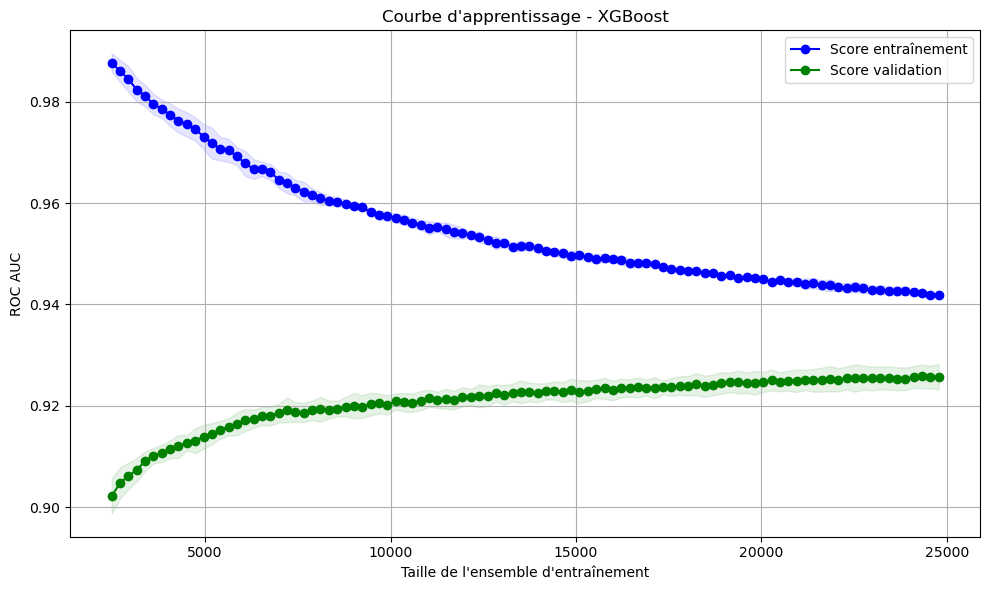

In [ ]:
lgbm = lgb.LGBMClassifier(random_state=42, objective='binary', metric="auc",)
lgbm.fit(X_train, y_train)


# La IA me ha permitido aqui de verificar si no hubo mucho overfiting
train_sizes, train_scores, val_scores = learning_curve(
    estimator=lgbm,
    X=X_train,
    y=y_train,
    train_sizes=np.linspace(0.1, 1.0, 100),
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1,
    shuffle=True,
    random_state=42
)


train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)


plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Score entraînement')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')

plt.plot(train_sizes, val_mean, 'o-', color='green', label='Score validation')
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1, color='green')

plt.title('Courbe d\'apprentissage - LGBM')
plt.xlabel('Taille de l\'ensemble d\'entraînement')
plt.ylabel('ROC AUC')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()


Parece que el modelo lgbm baseline no tiene overfiting con el train

## LGBM

He intentado hacer como en tu codigo que nos has compartido durante el apagon. He intentado encontrar los threshold que maximizan el f1 score weighted como tenemos un dataset debalanceado.

In [108]:
y_proba_test = lgbm.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_proba_test)

f1 = [f1_score(y_test, (y_proba_test >= t).astype(int), average='weighted') for t in thresholds]

best_idx = np.argmax(f1)
best_threshold = thresholds[best_idx]
print(f"Best threshold selon F1: {best_threshold:.3f}")
y_pred_test_threshold = (y_proba_test >= best_threshold).astype(int)

f1_weighted = f1_score(y_test, y_pred_test_threshold, average='weighted')
print(f"F1-score global (weighted): {f1_weighted:.3f}")

Best threshold selon F1: 0.435
F1-score global (weighted): 0.871


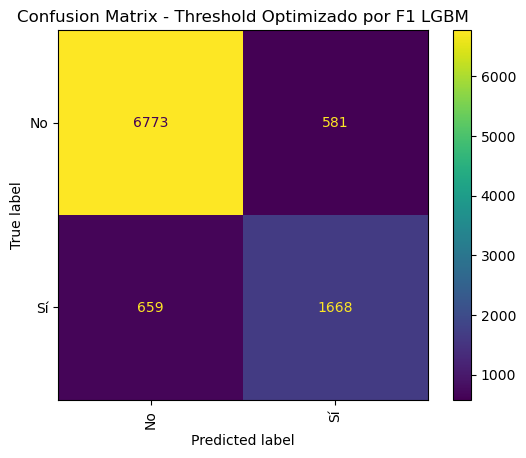

In [ ]:
cm = confusion_matrix(y_test, y_pred_test_threshold)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No', 'Sí'])
disp.plot(values_format='d', xticks_rotation='vertical')
plt.title("Confusion Matrix - Threshold Optimizado por F1 LGBM")
plt.savefig("../artefacts/LGBM.png", dpi=300)
plt.show()

## xgboost_best_rs

Best threshold selon F1: 0.722
F1-score global (weighted): 0.872


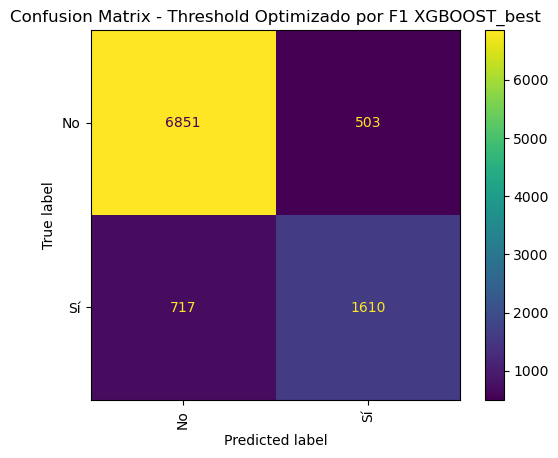

In [ ]:
y_proba_test = xgboost_best_rs.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_proba_test)

f1 = [f1_score(y_test, (y_proba_test >= t).astype(int), average='weighted') for t in thresholds]

best_idx = np.argmax(f1)
best_threshold = thresholds[best_idx]
print(f"Best threshold selon F1: {best_threshold:.3f}")
y_pred_test_threshold = (y_proba_test >= best_threshold).astype(int)

f1_weighted = f1_score(y_test, y_pred_test_threshold, average='weighted')
print(f"F1-score global (weighted): {f1_weighted:.3f}")

cm = confusion_matrix(y_test, y_pred_test_threshold)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No', 'Sí'])
disp.plot(values_format='d', xticks_rotation='vertical')
plt.title("Confusion Matrix - Threshold Optimizado por F1 XGBOOST_best")
plt.savefig("../artefacts/XGBOOST_best.png", dpi=300)
plt.show()

# Conclusion

Hemos visto que los modelos LGBM baseline y XGBoost optimizado ofrecen los mejores resultados al analizar el PR AUC, lo que indica una buena capacidad para detectar correctamente la clase positiva, especialmente en contextos con datos desbalanceados.

El problema es que, por ahora, no está claramente definido el propósito de la predicción, lo cual es esencial para elegir el mejor modelo. Dependiendo del uso final, el modelo optimo puede variar. He identificado dos posibles casos de uso:

- Si el objetivo es utilizar la prediccion para hacer estimaciones fiscales para el proximo ano, lo mas importante es detectar correctamente los positivos, es decir las personas con ingresos superiores a 50K. En este caso: Es preferible minimizar los falsos negativos (no pasar por alto a quienes realmente ganan >50K). Un modelo con alto recall seria el mas adecuado. El xgboost_best_rs es el mejor.

- Si el objetivo es utilizar el modelo para excluir de ciertos beneficios o ayudas a las personas con ingresos elevados, es crucial que: Cada prediccion positiva (persona con ingresos >50K) sea realmente fiable, para no cometer errores injustos. Se priorice la precision, es decir, minimizar los falsos positivos (evitar excluir por error a personas que si deberian recibir la ayuda). El lgbm es el mejor.

# Import model

In [ ]:
import pickle


with open('../artefacts/model_xgboost_best.pkl', 'wb') as file:
    pickle.dump(xgboost_best_rs, file)

with open('../artefacts/model_lgbm.pkl', 'wb') as file:
    pickle.dump(lgbm, file)

# Interpretability

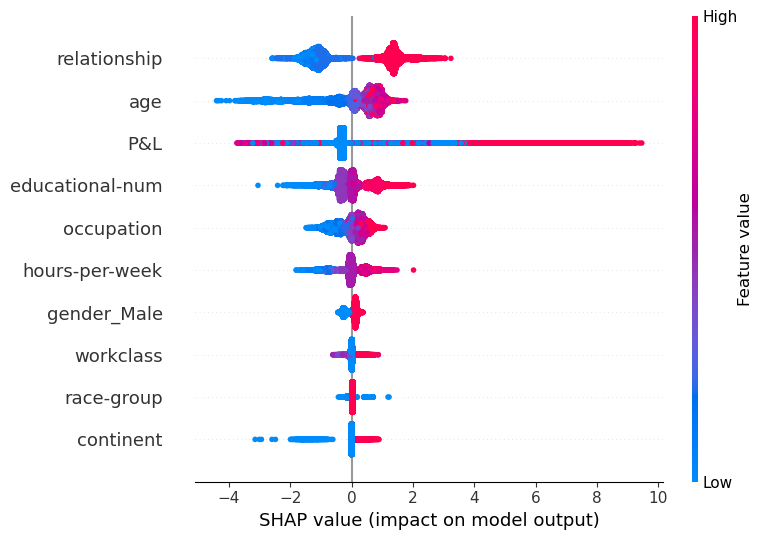

In [ ]:
import shap
# Esta parte lo he creado mirando un video youtube
# permite explicar un poquito mas lo que pasa dentro del modelo

X = full_pipeline.transform(df_processed.drop(columns=["income"]))
explainer = shap.TreeExplainer(lgbm)
shap_values = explainer.shap_values(X)

shap.summary_plot(shap_values, X)

De lo que podemos ver, relationship, age, P&L, education-num son las variables mas importantes. Esto lo hemos visto antes con features importance. Hemos visto en la EDA y con feature importance que continent, race-group, workclass y genero no tienen un gran poder predictivo para nuestra target. 

Se puede interpretar cada variable :
- relationship : perdemos informaciones con el target encoder pero parece tener mucho importancia en el prediccion
- age : se puede ver que cuanto mas mayor mas hay probabilidad de tener un salario de mas de 50K. Sin embargo no parece haber un edad especial para esto. Parece smooth. 
- P&L : es muy interesente porque aqui tambien se puede ver la personas con un apentencia a invertir. Sin embargo hay una mayor probabilidad de tener un sueldo de mas de 50K si tienes un P&L alto.
- Educational-num : cuanto mas alto el pretigio mas probabilidad de tener un sueldo alto
- Occupation : perdemos informaciones con el target encoder
- Hours-per-week : podemos ver que una persona que trabaja mucho tiene mas probabilidad de tener un sueldo alto pero no parece ser verdadero en todos los casos. 
- Gender :  es muy interesente aqui porque se puede ver que hay un problema de genero y que en general un mujer tiene menos probabilidad de tener un sueldo alto. Hay cosas a aprofundizar aqui porque no tenemos muchos datos de mujeres y tambien no se via bien con la EDA
- para worclass, race-group, continent perdemos informaciones tambien. 